## Simple Transformers 

In this notebook we use [Simple Transformer](https://simpletransformers.ai/) to do text classification on the German News Text.
The out of the box model was trained for 4 epochs (8 minutes per epoch) and in the end performed slightly better than the td idf based models.

Nevertheless predictions time increased compared to tf idf models.

Will not follow this model any further.

Check the summary table below

![classification_results_with_simpletransformer.png](classification_results_with_simpletransformer.png)

In [ ]:
!pip install pandas tqdm
!pip install torch simpletransformers

In [2]:
# Is the GPU available?
import torch
torch.cuda.is_available()

True

In [ ]:
!pip install git+https://github.com/TheoHelfenberger/fhnw-nlp-utils@fix_plot_feature_importance
!pip install pyarrow fastparquet

from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.processing import is_iterable
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import save_dataframe
from fhnw.nlp.utils.storage import load_dataframe

In [4]:
file = "data/german_news_articles_original_train_and_test_tokenized.parq"
data_all = load_dataframe(file)

In [7]:
data_all.sample(3)

,text_original,label,split,text_clean,token_clean,token_lemma,token_stem,token_clean_stopwords
2511,Auch Galaxy S6 Edge soll ab sofort beliefert w...,Web,train,Auch Galaxy Edge soll ab sofort beliefert werd...,"[galaxy, edge, ab, sofort, beliefert, neue, fu...","[galaxy, edge, ab, sofort, beliefern, neues, f...","[galaxy, edg, ab, sofort, beliefert, neu, funk...","[galaxy, edge, ab, sofort, beliefert, neue, fu..."
1305,Entscheidung über den neuen Direktor des Insti...,Wissenschaft,train,Entscheidung über den neuen Direktor des Insti...,"[entscheidung, neuen, direktor, instituts, höh...","[entscheidung, neu, direktor, institut, hoch, ...","[entscheid, neu, direktor, institut, hoh, stud...","[entscheidung, neuen, direktor, instituts, höh..."
1441,Vier Studierende sollen auf dem Weg zu ihrem A...,Panorama,train,Vier Studierende sollen auf dem Weg zu ihrem A...,"[vier, studierende, sollen, auto, schlagstöcke...","[vier, studierende, sollen, auto, schlagstöcke...","[vier, studier, soll, auto, schlagstock, attac...","[vier, studierende, sollen, auto, schlagstöcke..."


In [8]:
# Need to apply the Label Encoding
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

data_all.drop(columns=['label_encoded', 'label_onehot'], errors='ignore', inplace=True)
data_all['label_encoded'] = encoder.fit_transform(data_all['label'])

num_labels = len(encoder.classes_)
print(f'Number of classes {num_labels}')

Number of classes 9


In [12]:
# Check the results
encoder.transform(['Etat', 'Inland', 'International', 'Kultur', 'Panorama', 'Sport',
       'Web', 'Wirtschaft', 'Wissenschaft'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [11]:
# Tried to play around with different weights but did not follow that path further
import numpy as np
val_counts = data_all["label_encoded"].value_counts()
val_counts = val_counts / np.sum(val_counts) * 100.0
weight = (val_counts.astype(int)).sort_index().tolist()
weight

[6, 9, 14, 5, 16, 11, 16, 13, 5]

Total number of lines 10273
Percentage by label
Panorama         0.163341
Web              0.163243
International    0.147085
Wirtschaft       0.137350
Sport            0.116908
Inland           0.098803
Etat             0.065025
Wissenschaft     0.055777
Kultur           0.052468
Name: label, dtype: float64


array(['Etat', 'Inland', 'International', 'Kultur', 'Panorama', 'Sport',
       'Web', 'Wirtschaft', 'Wissenschaft'], dtype=object)

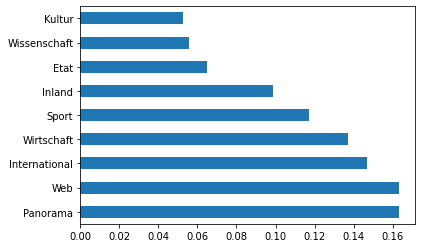

In [13]:
import numpy as np

val_counts = data_all["label"].value_counts()

print(f'Total number of lines {len(data_all)}')
print('Percentage by label')
val_counts = val_counts / np.sum(val_counts)
print(val_counts)
val_counts.plot(kind='barh')

encoder.classes_

In [15]:
# Rename columns to fit simpletransformer
data_all_renamed = data_all[['text_clean', 'label_encoded', 'split']]
data_all_renamed = data_all_renamed.rename(columns={'text_clean': 'text', 'label_encoded': 'labels'})

data_all_renamed.head(3)

,text,labels,split
0,Jähriger fällt wohl bis Saisonende aus Wien R...,5,train
1,Erfundene Bilder zu Filmen die als verloren ge...,3,train
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,6,train


In [16]:
# We try always to use the same split to be able to compare the results
data_train_orig = data_all_renamed.loc[(data_all["split"] == "train")]
data_test_orig = data_all_renamed.loc[(data_all["split"] == "test")]

In [17]:
# Get the simple transfomers classification model
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging

# Adjust loggin levels
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [19]:
# Optional model configuration
# We will use BERT german
model_args = ClassificationArgs(num_train_epochs=4, overwrite_output_dir=True, 
                                sliding_window=True)

# Create a ClassificationModel
model = ClassificationModel(
    'bert',
    'bert-base-german-cased',
    num_labels=len(data_train_orig['labels'].unique()),
    args=model_args,
    use_cuda = True,
    #weight=weight
) 

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [25]:
model.train_model(data_train_orig)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: Sliding window enabled
Token indices sequence length is longer than the specified maximum sequence length for this model (815 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (668 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/9245 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2427 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (628 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (794 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/5831 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/5831 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/5831 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/5831 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.


(23324, 0.10205436473649396)

In [27]:
from sklearn.metrics import classification_report

test_list = data_test_orig['text'].tolist()
y_test_pred, raw_outputs = model.predict(test_list)
y_test =  data_test_orig['labels'].tolist()

report = classification_report(y_test, y_test_pred)
print("Test:")
print(report)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: Sliding window enabled


  0%|          | 0/1028 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (820 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1566 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (565 > 512). Running this sequence through the model will result in indexing errors
INFO:simpletransformers.classification.classification_model: 1028 features created from 1028 samples.


  0%|          | 0/660 [00:00<?, ?it/s]

Test:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88        67
           1       0.83      0.88      0.86       102
           2       0.89      0.87      0.88       151
           3       0.84      0.87      0.85        54
           4       0.84      0.83      0.83       168
           5       0.99      0.97      0.98       120
           6       0.94      0.90      0.92       168
           7       0.87      0.89      0.88       141
           8       0.88      0.88      0.88        57

    accuracy                           0.89      1028
   macro avg       0.88      0.89      0.88      1028
weighted avg       0.89      0.89      0.89      1028



In [29]:
# We need to use the inverse transform to get from the integer values to the string classes again
# Otherwise we will not be able to compare the f1 score with the other models
y_test_pred_inv = encoder.inverse_transform(y_test_pred)
y_test_inv = encoder.inverse_transform(y_test)

In [30]:
# Add the f1 score to the file with the scores of the baseline models and the experiments
import os
import class_result

filename = 'data/overview_classification_results-with-transformer.csv'
df_classification_results = class_result.append_to_classification_report('f1-simpletransformer', y_test_inv, y_test_pred_inv, filename=filename)

print("All F1 Score - Maximum highlighted")
df_classification_results.style.highlight_max(color = 'lightblue', axis = 1)

All F1 Score - Maximum highlighted


,f1-baseline,f1-one vs one,f1-baseline 2 Gram,f1-kNN,f1-Random Forest,f1-Naiv Bayes,f1-baseline stemming,f1-baseline stemming optimized,f1-dummy clf,f1-simpletransformer
Etat,0.850394,0.848000,0.806723,0.753846,0.568421,0.029412,0.852713,0.859375,0.031746,0.884058
Inland,0.835821,0.827586,0.831683,0.770563,0.780488,0.717647,0.848485,0.869565,0.040201,0.857143
International,0.855172,0.849123,0.823529,0.813115,0.788274,0.830450,0.851351,0.851351,0.190184,0.876254
Kultur,0.854545,0.811321,0.890909,0.742268,0.804124,0.000000,0.859813,0.878505,0.055556,0.854545
Panorama,0.829412,0.802228,0.804598,0.738028,0.717087,0.631791,0.838150,0.826347,0.197015,0.832335
Sport,0.991667,0.978903,0.991667,0.962343,0.970464,0.948718,0.987448,0.991667,0.150794,0.978903
Web,0.908012,0.900901,0.908012,0.835913,0.850000,0.756219,0.925373,0.923077,0.127796,0.917933
Wirtschaft,0.849315,0.813559,0.823129,0.747253,0.719723,0.785965,0.851211,0.844291,0.141343,0.877193
Wissenschaft,0.924370,0.902655,0.905983,0.796117,0.844037,0.000000,0.905983,0.905983,0.052632,0.877193
accuracy,0.876459,0.857977,0.861868,0.799611,0.790856,0.694553,0.880350,0.881323,0.131323,0.885214


Set Population: 1028
Accuracy: 0.8852


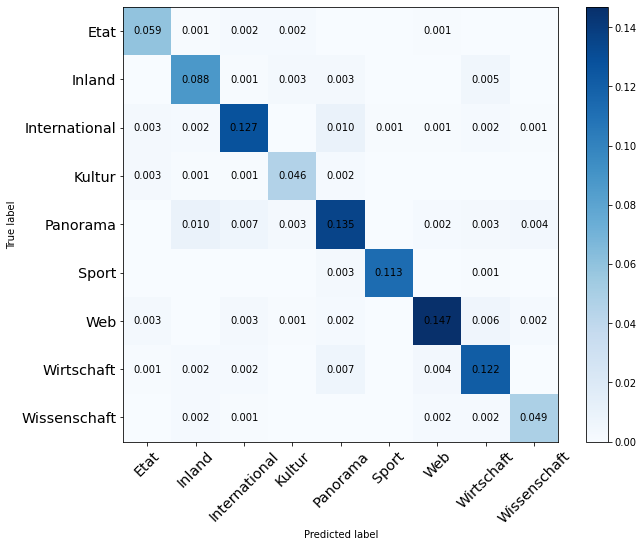

In [31]:
from fhnw.nlp.utils.ploting import plot_confusion_matrix
plot_confusion_matrix(y_test_inv, y_test_pred_inv)